# Viosk

In [6]:
import numpy as np
import pandas as pd
from os import path
import matplotlib.pyplot as plt
import scipy.io as io
from tqdm import tqdm
from PIL import Image, ImageOps
from numpy import asarray
from datetime import date
from sklearn.preprocessing import OneHotEncoder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Dataset
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

In [7]:
JYLee_path = './gdrive/My Drive/2020/Viosk'
print(path.isdir(JYLee_path))

True


In [8]:
meta_data = io.loadmat(JYLee_path + '/dataset/wiki/wiki.mat')
print(meta_data)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Jan 16 16:25:20 2016', '__version__': '1.0', '__globals__': [], 'wiki': array([[(array([[723671, 703186, 711677, ..., 720620, 723893, 713846]], dtype=int32), array([[2009, 1964, 2008, ..., 2013, 2011, 2008]], dtype=uint16), array([[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31'),
        array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31'),
        array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29'), ...,
        array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30'),
        array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30'),
        array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]],
      dtype=object), array([[1., 1., 1., ..., 1., 1., 0.]]), array([[array(['Sami Jauhojärvi'], dtype='<U15'),
        array(['Dettmar Cramer'], dtype='<U14'),
        array(['Marc Okrand'], dtype='<U11'), ...,
        array(['Michael Wiesinger'], dtype='<U17'),
        array(['Johann Grugger'], dtype='<U

#### Analysis

##### Image

In [14]:
# Dataset Preparation
meta_data = io.loadmat(JYLee_path + '/dataset/wiki/wiki.mat')

total_samples = len(meta_data['wiki']['dob'][0][0][0])
print(total_samples)
total_samples = 2

62328


In [20]:
img_list = []
for idx in tqdm(range(total_samples)):
    img = Image.open( JYLee_path + '/dataset/wiki/' + meta_data['wiki']['full_path'][0][0][0][idx][0] )
    img = img.resize((200, 200))
    img = ImageOps.grayscale(img)
        
    img = asarray(img)
    if img.shape != (200, 200):
        continue
    img = img / 255.0
    img_list.append(img)

img_data = np.array(img_list)
img_data = img_data.reshape((-1, 200, 200, 1))
print(img_data.shape)

100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

(2, 200, 200, 1)


##### Label

100%|██████████| 2/2 [00:00<00:00, 3087.45it/s]


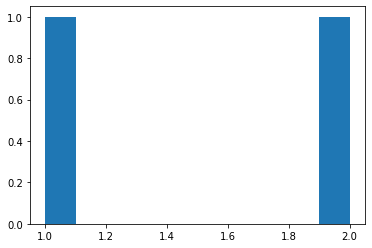

(2, 4)


In [21]:
label_data = []
for idx in tqdm(range(total_samples)): 
    photo_taken = date.toordinal(date(meta_data['wiki']['photo_taken'][0][0][0][idx], 7, 1))
    age = photo_taken - meta_data['wiki']['dob'][0][0][0][idx]
    age = age / 365

    if(age <= 10):
        age_class = 0
    elif(age <= 30):
        age_class = 1
    elif(age <= 55):
        age_class = 2
    else:
        age_class = 3
    
    label_data.append([age_class])

label_data = np.array(label_data)
plt.hist(label_data)
plt.show()

enc = OneHotEncoder()
enc.fit(np.array([[0], [1], [2], [3]]).reshape((-1, 1)))
label_data = enc.transform(label_data).toarray()
print(label_data.shape)

## Model

In [22]:
import tensorflow as tf
from tensorflow import keras
import os

print(tf.__version__)

2.4.0


### Training

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()
model.add(Conv2D(48, kernel_size=7, strides=4, activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Conv2D(120, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [25]:
ckpt_path = "ckpts/best_model.h5"
ckpt_dir = os.path.dirname(ckpt_path)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path, 
    save_weights_only=True,
    save_best_only=True,
    monitor='accuracy'
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(img_data, label_data, epochs=200, callbacks=[ckpt_callback])

Epoch 1/2
1/1 [==============================] - 7s 7s/step - loss: 1.4355 - accuracy: 0.0000e+00
Epoch 2/2
1/1 [==============================] - 0s 6ms/step - loss: 1.2980 - accuracy: 1.0000


### Lightweight

In [ ]:
model.load_weights('ckpts/200x200/best_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model_fp = converter.convert()
with tf.io.gfile.GFile('model_200x200_fp32.tflite', 'wb') as f:
    f.write(tflite_model_fp)